# Linear elasticity

Whenever a force or a load is applied to a solid, the body deforms. Stress analysis relate loads and deformations. Elasticity theory deals with small (reversible) deformations, i.e., the body returns to its original size and shape when the load is removed. Within this range, the distances between atoms in the solid, or, alternatively, the atom–atom bonds, are stretched or compressed, but not broken. In order to remain in the elastic range, the fractional changes in interatomic distances (on a microscopic scale) or in the body’s gross dimensions (on a macroscopic scale) must be less than 0.2%. When loads or deformations exceed the elastic range, the changes in the shape of the body are not recovered when the load is removed. This type of irreversible deformation is defined plastic deformation. On a microscopic level, atomic bonds are broken and new bonds are formed. The maximum extent of plastic deformation is breakage or fracture of the material. Instead of load (or force) and deformation, elasticity theory utilizes the related quantities stress and strain. 

## Problem equations
The equations governing the linear elastic problem for an isotropic body $\Omega$ can be written as:

$$
\begin{align}
    &\nabla \cdot \sigma + f = 0, && \quad \text{equilibrium condition} \\
    &\sigma= \lambda \mathrm{tr}(\epsilon)I + 2 \mu \epsilon, &&\quad \text{constitutive equation} \\
    &\epsilon= \frac{1}{2}\left(\nabla u + (\nabla u )^T\right), && \quad \text{strain compatibility equation}
\end{align}
$$

where $\sigma$ is the stress tensor, $f$ is the body force per unit volume, $\lambda$ and $\mu$ are Lamé parameters for the material in $\Omega$, $I$ is the identity tensor, $\mathrm{tr}$ is the trace operator on a tensor, $\epsilon$ is the symmetric strain tensor, and $u$ is the displacement vector field.

### Material properties
Since we are assuming a material macroscopically homogeneous (same physical properties at every point) and isotropic (same physical properties in any direction): the physical relationship can be expressed by only 2 (independent) elastic constants, the Lamé parameters. The Lamé parameters and conventional elastic moduli ($E$, $\nu$, $G$) are linked by the following relation:

$$
\begin{align}
    &E = \frac{\mu(\lambda + 2\mu)}{\lambda + \mu} \\
    &\nu = \frac{\lambda}{2(\lambda + \mu)} \\
    &G = \frac{E}{2(1 + \nu)} = \mu 
\end{align}
$$
In addition, we recall that the Lamé first parameter can be calculated as $\lambda = \frac{\nu E}{(1+\nu)(1-2\nu)}$.

By using the strain compatibility equation in the constitutive equation, we get:
$$
\begin{align}
    \sigma &= \lambda(\nabla \cdot u)I + \mu(\nabla u + (\nabla u)^T)
\end{align}
$$

Note that we could have written the PDE above as a single vector PDE for $u$, which is the governing PDE for the unknown $u$ (Navier's) equation. However, it is convenient to keep the current representation of the PDE for the derivation of the variational formulation.

## The variational formulation
The variational formulation of the PDE consists of forming the inner product of the PDE with a *vector* test function $v\in\hat{V}$, where $\hat{V}$ is a vector-valued test function space, and integrating over the domain $\Omega$:
$$
\begin{align}
    -\int_{\Omega}(\nabla \cdot \sigma)\cdot v ~\mathrm{d} x = \int_{\Omega} f\cdot v ~\mathrm{d} x.
\end{align}
$$ù

Since $\nabla \cdot \sigma$ contains second-order derivatives of our unknown $u$, we integrate this term by parts
$$
    -\int_{\Omega}(\nabla \cdot \sigma)\cdot v ~\mathrm{d} x =\int_{\Omega}\sigma : \nabla v ~\mathrm{d}x - \int_{\partial\Omega} (\sigma \cdot n)\cdot v~\mathrm{d}x,
$$

where the colon operator is the inner product between tensors (summed pairwise product of all elements), and $n$ is the outward unit normal at the boundary. The quantity $\sigma \cdot n$ is known as the *traction* or stress vector at the boundary, and often prescribed as a boundary condition. We here assume that it is prescribed on a part $\partial \Omega_T$ of the boundary as $\sigma \cdot n=T$. On the remaining part of the boundary, we assume that the value of the displacement is given as Dirichlet condition (and hence the boundary integral on those boundaries are $0$). We thus obtain:
$$
    \int_{\Omega} \sigma : \nabla v ~\mathrm{d} x = \int_{\Omega} f\cdot v ~\mathrm{d} x + \int_{\partial\Omega_T}T \cdot v~\mathrm{d} s.
$$

If we now insert for $\sigma$ its representation with the unknown $u$, we can obtain our variational formulation: Find $u\in V$ such that 
$$
    a(u,v) = L(v)\qquad  \forall v \in \hat{V},
$$

where
$$
\begin{align}
    a(u,v)&=\int_{\Omega}\sigma(u):\nabla v ~\mathrm{d}x\\
    \sigma(u)&=\lambda(\nabla \cdot u)I+\mu (\nabla u + (\nabla u)^T)\\
    L(v)&=\int_{\Omega}f\cdot v~\mathrm{d} x + \int_{\partial\Omega_T}T\cdot v~\mathrm{d}s
\end{align}
$$

One can show that the inner product of a symmetric tensor $A$ and an anti-symmetric tensor $B$ vanishes. If we express $\nabla v$ as a sum of its symmetric and anti-symmetric parts, only the symmetric part will survive in the product $\sigma : \nabla v$ since $\sigma$ is a symmetric tensor. Thus replacing $\nabla v$ by the symmetric gradient $\epsilon(v)$ gives rise to a slightly different variational form
$$

    a(u,v)= \int_{\Omega}\sigma(u):\epsilon(v)~\mathrm{d} x,
$$
where $\epsilon(v)$ is the symmetric part of $\nabla v$:
$$
    \epsilon(v)=\frac{1}{2}\left(\nabla v + (\nabla v)^T\right)
$$
The formulation is what naturally arises from minimization of elastic potential energy and is a more popular formulation than the original formulation.

## Implementation
The modules that will be used are imported:

In [89]:
import numpy as np

import ufl
from ufl import ds, dx, grad, inner

from dolfinx import fem, io, mesh, plot, log
from dolfinx.io import gmshio # to import gmsh functions
from dolfinx import geometry # to define the line plot
from dolfinx import default_scalar_type
import dolfinx.fem.petsc

from mpi4py import MPI

from petsc4py.PETSc import ScalarType

import matplotlib.pyplot as plt
import matplotlib as mpl


In [90]:
class LinearElasticity:
    def __init__(self, mesh_file, rank=0, gdim=3):
        """
        Initialize the LinearElasticity class with the mesh file.

        Parameters:
        mesh_file (str): Path to the mesh file.
        rank (int): Rank of the process (default is 0).
        gdim (int): Geometric dimension of the mesh (default is 3).
        """
        self.mesh_file = mesh_file
        self.rank = rank
        self.gdim = gdim
        self._read_mesh()
        self._setup_function_space()
        self._initialize_functions()

    def _read_mesh(self):
        """
        Read the mesh and facet tags from the specified mesh file.
        """
        try:
            self.domain, self.tags, self.ft = gmshio.read_from_msh(self.mesh_file, MPI.COMM_WORLD, rank=self.rank, gdim=self.gdim)
            self.tdim = self.domain.topology.dim
            self.fdim = self.tdim - 1
            self.domain.topology.create_connectivity(self.fdim, self.tdim)
        except Exception as e:
            raise ValueError(f"Error reading mesh file {self.mesh_file}: {e}")

    def _setup_function_space(self):
        """
        Set up the function space for the problem.
        """
        self.V = fem.functionspace(self.domain, ("Lagrange", 1, (self.domain.geometry.dim,)))

    def _initialize_functions(self):
        """
        Initialize trial and test functions.
        """
        self.u = ufl.TrialFunction(self.V)
        self.v = ufl.TestFunction(self.V)

    def parameters(self, rho, g, lmbda, mu):
        """
        Set material and physical parameters.

        Parameters:
        rho (float): Density.
        g (float): Gravitational acceleration.
        lmbda (float): First Lamé parameter.
        mu (float): Second Lamé parameter.
        """
        self.rho = rho
        self.g = g
        self.lmbda = lmbda
        self.mu = mu

    def boundary_conditions(self, internal_pressure, outer_pressure):
        """
        Define and set the boundary conditions.
        """
        
        # Locate dofs for Dirichlet boundary conditions
        self.dofs_D_top     = fem.locate_dofs_topological(V=self.V, entity_dim=self.fdim, entities=self.ft.find(7))
        self.dofs_D_bottom  = fem.locate_dofs_topological(V=self.V, entity_dim=self.fdim, entities=self.ft.find(8))
        self.dofs_D_outer   = fem.locate_dofs_topological(V=self.V, entity_dim=self.fdim, entities=self.ft.find(9))
        self.dofs_D_inner   = fem.locate_dofs_topological(V=self.V, entity_dim=self.fdim, entities=self.ft.find(10))

        # Dirichlet boundary conditions
        self.bc_top     = fem.dirichletbc(np.array([0, 0, 0], dtype=default_scalar_type), dofs=self.dofs_D_top, V=self.V)
        self.bc_bottom  = fem.dirichletbc(np.array([0, 0, 0], dtype=default_scalar_type), dofs=self.dofs_D_bottom, V=self.V)
        self.bc_outer   = fem.dirichletbc(np.array([0, 0, 0], dtype=default_scalar_type), dofs=self.dofs_D_outer, V=self.V)
        self.bc_inner   = fem.dirichletbc(np.array([0, 0, 0], dtype=default_scalar_type), dofs=self.dofs_D_inner, V=self.V)

        self.bc = [self.bc_top, self.bc_bottom]

        # Neumann boundary conditions
        self.normal = ufl.FacetNormal(self.domain)
        self.pressure_inner = fem.Constant(self.domain, default_scalar_type(internal_pressure))
        self.pressure_outer = fem.Constant(self.domain, default_scalar_type(outer_pressure))
        
        self.traction_inner = self.pressure_inner * self.normal
        self.traction_outer = self.pressure_outer * self.normal

    def assemble_system(self):
        """
        Assemble the system for the linear elasticity problem.
        """
        def sigma(u, lmbda, mu):
            return lmbda * ufl.nabla_div(u) * ufl.Identity(len(u)) + 2 * mu * epsilon(u)

        def epsilon(u):
            return ufl.sym(ufl.grad(u))

        # Body forces
        self.f = fem.Constant(self.domain, ScalarType((0.0, 0.0, - self.rho * self.g)))

        self.ds = ufl.Measure("ds", domain=self.domain, subdomain_data=self.ft)
        ds_in = self.ds(10)
        ds_out = self.ds(9)

        self.a = ufl.inner(sigma(self.u, self.lmbda, self.mu), epsilon(self.v)) * ufl.dx
        self.L = ufl.dot(self.f, self.v) * ufl.dx + ufl.dot(self.traction_outer, self.v) * ds_out + ufl.dot(self.traction_inner, self.v) * ds_in

    def solve(self):
        """
        Solve the linear elasticity problem.
        """
        self.problem = fem.petsc.LinearProblem(self.a, self.L, bcs=self.bc, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
        self.displacement = self.problem.solve()

        def sigma(u, lmbda, mu):
            return lmbda * ufl.nabla_div(u) * ufl.Identity(len(u)) + 2 * mu * epsilon(u)

        def epsilon(u):
            return ufl.sym(ufl.grad(u))

        self.stress_field = sigma(self.displacement, self.lmbda, self.mu)
        self.strain_field = epsilon(self.displacement)

    def get_results(self):
        """
        Get the computed displacement, stress, and strain fields.

        Returns:
        displacement (Function): The displacement field.
        stress_field (ufl.Expr): The stress field.
        strain_field (ufl.Expr): The strain field.
        """
        return self.displacement, self.stress_field, self.strain_field

In [91]:
# Scaled variable
E = 1e9 # Pa
nu = 0.33
G = E / (2*(1+nu))
lame1 = nu * E /((1+nu)*(1-2*nu))
lame2 = G

internal_pressure = -1e7
outer_pressure = 0

print(f"Young's modulus = {E*1e-9:.2f} GPa")
print(f"Poisson's ratio = ", nu)
print(f"Shear modulus = {G*1e-9:.2f} GPa")
print(f"Lamé first parameter = {lame1*1e-9:.2f} GPa")
print(f"Lamé second parameter = {lame2*1e-9:.2f} GPa")

rho = 9560 # kg/m3
g = 9.81

problem = LinearElasticity(mesh_file='./cylindrical_shell.msh')

# Volume of the mesh = volume integral
dx_subdomain = ufl.Measure("dx", domain=problem.domain)
volume = fem.assemble_scalar(fem.form(1 * dx_subdomain))
print("---------")
print(f"Caclulated volume = ", volume)
print(f"Analytical volume = {3.14*(5**2 - 4.5**2)*4}")

problem.parameters(rho, g / volume, lame1, lame2)
problem.boundary_conditions(internal_pressure=internal_pressure, outer_pressure=outer_pressure)
problem.assemble_system()
problem.solve()
displacement, stress_field, strain_field = problem.get_results()



Young's modulus = 1.00 GPa
Poisson's ratio =  0.33
Shear modulus = 0.38 GPa
Lamé first parameter = 0.73 GPa
Lamé second parameter = 0.38 GPa
Info    : Reading './cylindrical_shell.msh'...
Info    : 15 entities
Info    : 1386 nodes
Info    : 7056 elements
Info    : Done reading './cylindrical_shell.msh'
---------
Caclulated volume =  59.66881083605438
Analytical volume = 59.660000000000004


2024-07-31 17:41:17.427 (6833.190s) [main            ]         graphbuild.cpp:356   INFO| Build local part of mesh dual graph
2024-07-31 17:41:17.430 (6833.193s) [main            ]           ordering.cpp:204   INFO| GPS pseudo-diameter:(69) 2875-0
2024-07-31 17:41:17.431 (6833.194s) [main            ]           Topology.cpp:1330  INFO| Create topology (single cell type)
2024-07-31 17:41:17.431 (6833.194s) [main            ]           Topology.cpp:1044  INFO| Create topology (generalised)
2024-07-31 17:41:17.431 (6833.194s) [main            ]                MPI.cpp:164   INFO| Computing communication graph edges (using NBX algorithm). Number of input edges: 1
2024-07-31 17:41:17.431 (6833.194s) [main            ]                MPI.cpp:235   INFO| Finished graph edge discovery using NBX algorithm. Number of discovered edges 1
2024-07-31 17:41:17.432 (6833.195s) [main            ]          partition.cpp:233   INFO| Compute ghost indices
2024-07-31 17:41:17.432 (6833.195s) [main          

## Visualization
displayed using [pyvista](https://docs.pyvista.org/).


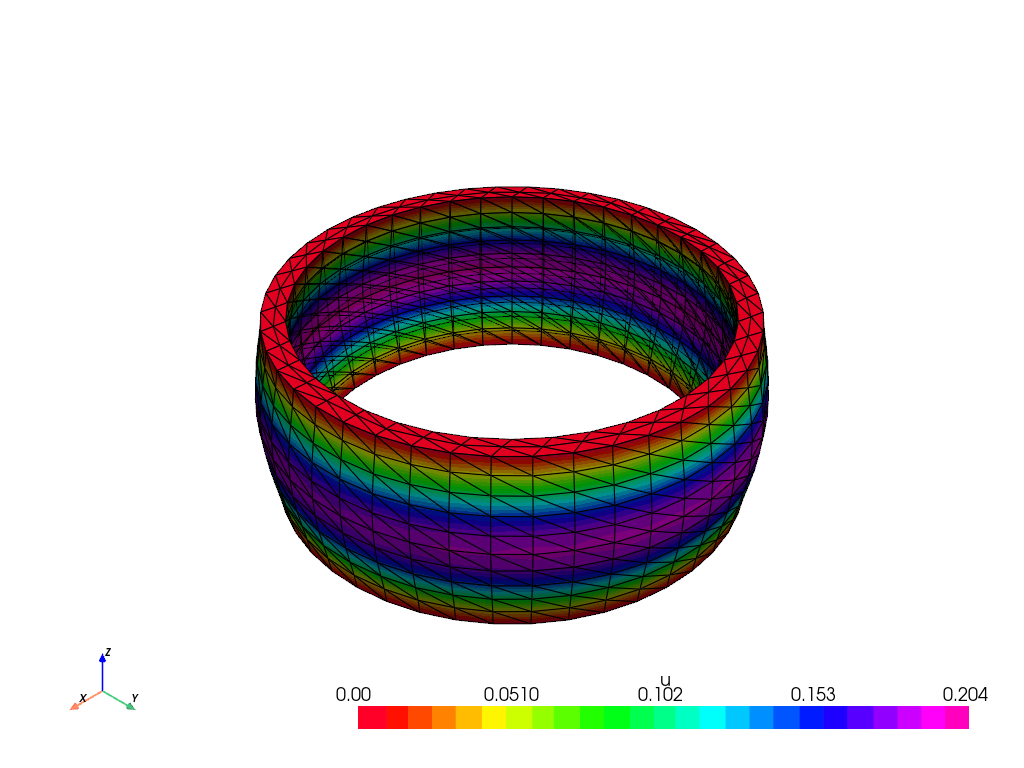

In [102]:
import pyvista
pyvista.start_xvfb()

# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(problem.V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
grid["u"] = displacement.x.array.reshape((geometry.shape[0], 3))
p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.5)
p.add_mesh(warped, show_edges=True, cmap=mpl.colormaps.get_cmap("gist_rainbow").resampled(25))
p.show_axes()

if not pyvista.OFF_SCREEN:
   p.show()
else:
   figure_as_array = p.screenshot("deflection.png")

# Paraview file
# with io.XDMFFile(problem.domain.comm, "deformation.xdmf", "w") as xdmf:
#     xdmf.write_mesh(problem.domain)
#     displacement.name = "Deformation"
#     xdmf.write_function(displacement)

## Stress computation
As soon as the displacement is computed, we can compute various stress measures. We will compute the von Mises stress defined as $\sigma_m=\sqrt{\frac{3}{2}s:s}$ where $s$ is the deviatoric stress tensor $s(u)=\sigma(u)-\frac{1}{3}\mathrm{tr}(\sigma(u))I$.

2024-07-31 17:37:41.108 (6616.871s) [main            ]      dofmapbuilder.cpp:166   INFO| Checking required entities per dimension
2024-07-31 17:37:41.109 (6616.871s) [main            ]      dofmapbuilder.cpp:264   INFO| Cell type:0, dofmap:5040x1
2024-07-31 17:37:41.109 (6616.871s) [main            ]      dofmapbuilder.cpp:320   INFO| Global index computation
2024-07-31 17:37:41.109 (6616.871s) [main            ]      dofmapbuilder.cpp:637   INFO| Got 1 index_maps
2024-07-31 17:37:41.109 (6616.871s) [main            ]      dofmapbuilder.cpp:644   INFO| Get global indices


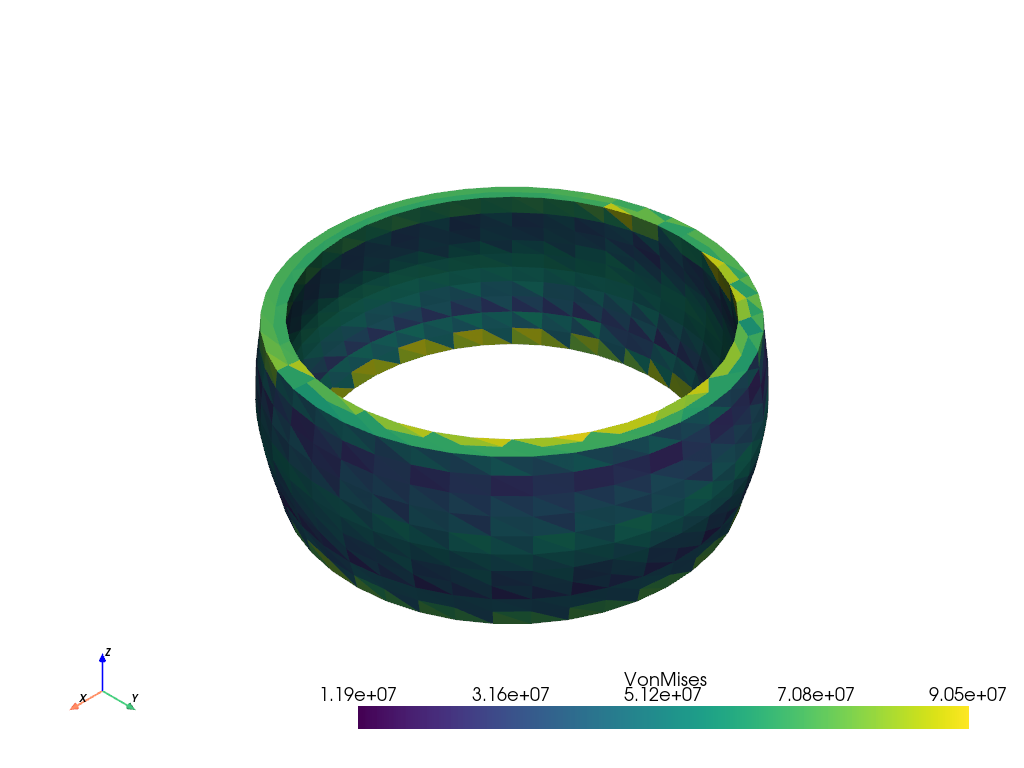

In [ ]:
deviatoric_stress = stress_field -1./3*ufl.tr(problem.stress_field)*ufl.Identity(len(problem.displacement))
von_Mises = ufl.sqrt(3./2*ufl.inner(deviatoric_stress, deviatoric_stress))

V_von_mises = fem.functionspace(problem.domain, ("DG", 0))
stress_expr = fem.Expression(von_Mises, V_von_mises.element.interpolation_points())
stresses = fem.Function(V_von_mises)
stresses.interpolate(stress_expr)

warped.cell_data["VonMises"] = stresses.vector.array
warped.set_active_scalars("VonMises")
p = pyvista.Plotter()
p.add_mesh(warped)
p.show_axes()
if not pyvista.OFF_SCREEN:
   p.show()
else:
   stress_figure = p.screenshot(f"stresses.png")

2024-07-31 17:37:44.353 (6620.116s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-07-31 17:37:44.355 (6620.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-07-31 17:37:44.355 (6620.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-07-31 17:37:44.355 (6620.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-07-31 17:37:44.355 (6620.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-07-31 17:37:44.566 (6620.329s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-07-31 17:37:44.568 (6620.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-07-31 17:37:44.568 (6620.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting

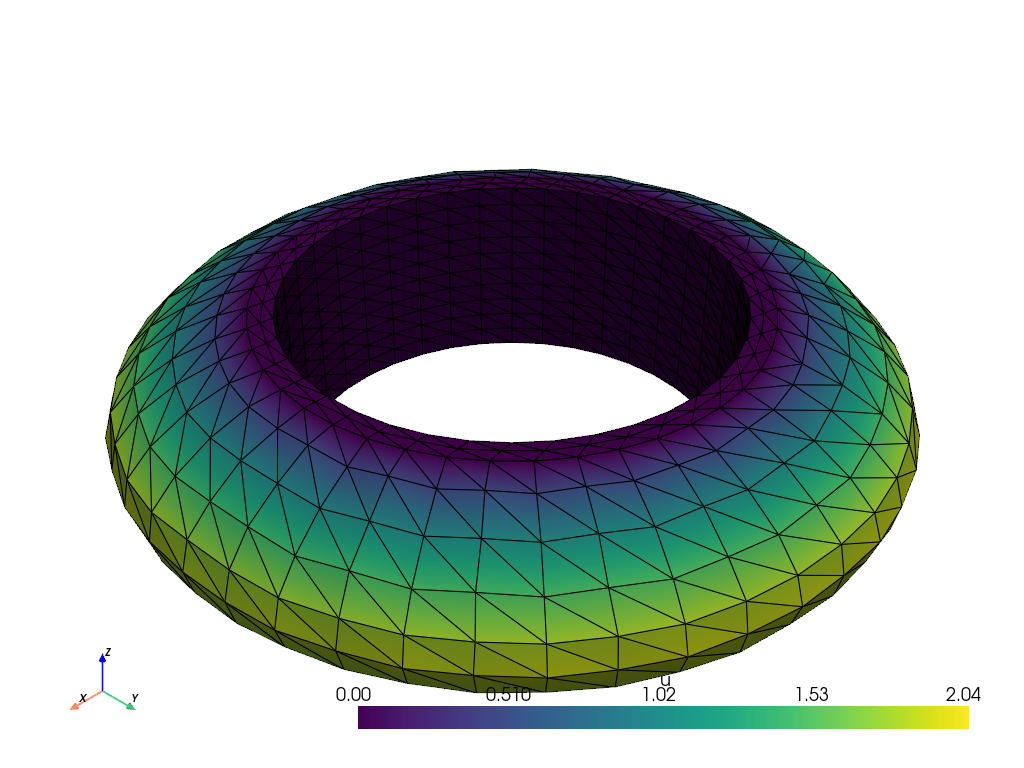

In [ ]:
pyvista.start_xvfb()
p = pyvista.Plotter()

p.open_gif("deformation.gif", fps=3)

topology, cells, geometry = plot.vtk_mesh(problem.V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

domain = problem.domain

log.set_log_level(log.LogLevel.INFO)

for n in range(1, 9):
    internal_pressure = -10.0**n

    # update
    problem.boundary_conditions(internal_pressure=internal_pressure, outer_pressure=0.0)
    problem.assemble_system()
    problem.solve()
    displacement, stress_field, strain_field = problem.get_results()

    grid["u"] = displacement.x.array.reshape((geometry.shape[0], 3))
    actor_0 = p.add_mesh(grid, style="wireframe", color="k")
    warped = grid.warp_by_vector("u", factor=1.5)
    actor_1 = p.add_mesh(warped, show_edges=True)
    p.show_axes()

    # Warp mesh by deformation
    # warped = function_grid.warp_by_vector("u", factor=1)
    # warped.set_active_vectors("u")

    # Add mesh to plotter and visualize
    # actor = plotter.add_mesh(warped, show_edges=True, lighting=False, clim=[0, 10])

    # u.x.scatter_forward()

    # magnitude.interpolate(us)
    # warped.set_active_scalars("mag")
    # warped_n = function_grid.warp_by_vector(factor=1)
    # warped.points[:, :] = warped_n.points
    # warped.point_data["mag"][:] = magnitude.x.array
    # plotter.update_scalar_bar_range([0, 10])
    p.write_frame()

p.show()
